In [1]:
from google_play_scraper import app
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np

from lbl2vec import Lbl2Vec
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import strip_tags
from sklearn.metrics import f1_score

In [6]:
result, continuation_token = reviews(
    'com.dafturn.mypertamina',
    lang='id', 
    country='id', 
    sort=Sort.MOST_RELEVANT, 
    count=30000, 
    filter_score_with=None
)

In [7]:
df = pd.DataFrame.from_dict(result)
df = df[['userName', 'score','at', 'content']]

In [8]:
import re
def cleaningulasan(ulasan):
  ulasan = re.sub(r'@[A-Za-a0-9]+',' ',ulasan)
  ulasan = re.sub(r'#[A-Za-z0-9]+',' ',ulasan)
  ulasan = re.sub(r"http\S+",' ',ulasan)
  ulasan = re.sub(r'[0-9]+',' ',ulasan)
  ulasan = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", ulasan)
  ulasan = ulasan.strip(' ')
  return ulasan

def clearEmoji(ulasan):
    return ulasan.encode('ascii', 'ignore').decode('ascii')

def replaceTOM(ulasan):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', ulasan)

def casefoldingText(ulasan):
  ulasan = ulasan.lower()
  return ulasan

In [9]:
df['Cleaning']= df['content'].apply(cleaningulasan)
df['HapusEmoji']= df['Cleaning'].apply(clearEmoji)
df['3/Lebih']= df['HapusEmoji'].apply(replaceTOM)
df['CaseFolding']= df['3/Lebih'].apply(casefoldingText)

In [10]:
def convertToSlangword(ulasan):
    kamusSlang = eval(open("NLP_bahasa_resources-master\combined_slang_words.txt").read())
    content = []
    for kata in ulasan.split():
        try:
            content.append(kamusSlang[kata])
        except:
            content.append(kata)
    ulasan = ' '.join(content)
    return ulasan

df['Formalisasi'] = df['CaseFolding'].apply(convertToSlangword)

In [11]:
positive = pd.read_csv('InSet-master\positive.tsv', sep='\t', index_col='word')
negative = pd.read_csv('InSet-master\\negative.tsv', sep='\t', index_col='word')

inset = pd.concat([positive, negative]).to_dict()['weight']
# positive = positive.to_dict()['weight']
# negative = negative.to_dict()['weight']

In [12]:
def sentiment_score(ulasan):
    inset_score = 0
    for kata in ulasan.split():
        try:
            inset_score += inset[kata]
        except:
            inset_score += 0

    return inset_score

df['sentiment_score'] = df['CaseFolding'].apply(sentiment_score)

In [13]:
df = df[['userName', 'score','at', 'content', 'Formalisasi', 'sentiment_score']]
df

,userName,score,at,content,Formalisasi,sentiment_score
0,cool_ _id,1,2022-09-11 15:04:14,"Aplikasi ini sangat menyusahkan, baik dari cus...",aplikasi ini sangat menyusahkan baik dari cust...,-54
1,Akun Gmail,1,2022-09-22 16:19:19,dari segi grafik sudah mantep di grafik tinggi...,dari segi grafik sudah mantap di grafik tinggi...,-57
2,Ris Mawardi,1,2022-09-13 07:20:28,Sudah daftar dan sudah isi data lengkap. Katan...,sudah daftar dan sudah isi data lengkap katany...,-31
3,Ali Ms,1,2022-08-31 22:56:00,Sebaiknya bagi yg darah tinggi tidak mendaftar...,sebaiknya bagi yang darah tinggi tidak mendaft...,-37
4,rudy tedjo,1,2022-07-28 18:11:45,"Aplikasi tidak membantu, klik back langsung da...",aplikasi tidak membantu klik back langsung dat...,-27
...,...,...,...,...,...,...
29995,Fahrul Ardiansyah,1,2022-07-03 19:53:33,"Mau dibayar buat riview baguspun gw ogah sih, ...",mau dibayar buat riview baguspun saya tidak ma...,-5
29996,Maulana NR,1,2022-07-03 19:54:37,at least kalo mau bikin aplikasi yg masuk akal...,at least kalau mau bikin aplikasi yang masuk a...,-8
29997,Mediy Cbr,1,2022-06-30 09:24:46,aplilasih ga ada berguna nya klo pake aplikasi...,aplilasih ga ada berguna nya kalau pakai aplik...,-12
29998,Musa Aljamilツ,1,2022-07-04 11:36:17,Aku suka banget game fri fayer 🤗 tapi sayang a...,aku suka banget game fri fayer tapi sayang aku...,-17


In [14]:
df.to_csv('review_mypertamina.csv', index=False)

In [15]:
labels = pd.read_csv('label_keyword.csv',sep=';')
labels['keywords'] = labels['keywords'].apply(lambda x: x.lower().split(' '))
labels['number_of_keywords'] = labels['keywords'].apply(lambda row: len(row))

In [16]:
labels

,class_index,class_name,keywords,number_of_keywords
0,1,user_experience,"[menyusahkan, susah, sulit, mempersulit, belum...",13
1,2,jaringan_dan_koneksi,"[sinyal, stabil, wifi, loading, gangguan, jari...",7
2,3,payment,"[pembayaran, payment, linkaja, transfer, bank,...",9
3,4,security,"[data, pribadi, sistem, retas]",4
4,5,invalid_troll,"[war, player, pemain, game, gameplay, lvl, sen...",16


In [17]:
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)

In [18]:
df.head()

,userName,score,at,content,Formalisasi,sentiment_score
0,cool_ _id,1,2022-09-11 15:04:14,"Aplikasi ini sangat menyusahkan, baik dari cus...",aplikasi ini sangat menyusahkan baik dari cust...,-54
1,Akun Gmail,1,2022-09-22 16:19:19,dari segi grafik sudah mantep di grafik tinggi...,dari segi grafik sudah mantap di grafik tinggi...,-57
2,Ris Mawardi,1,2022-09-13 07:20:28,Sudah daftar dan sudah isi data lengkap. Katan...,sudah daftar dan sudah isi data lengkap katany...,-31
3,Ali Ms,1,2022-08-31 22:56:00,Sebaiknya bagi yg darah tinggi tidak mendaftar...,sebaiknya bagi yang darah tinggi tidak mendaft...,-37
4,rudy tedjo,1,2022-07-28 18:11:45,"Aplikasi tidak membantu, klik back langsung da...",aplikasi tidak membantu klik back langsung dat...,-27


In [19]:
df['tagged_docs'] = df.apply(lambda row: TaggedDocument(tokenize(row['Formalisasi']), [str(row.name)]), axis=1)

In [20]:
df.head()

,userName,score,at,content,Formalisasi,sentiment_score,tagged_docs
0,cool_ _id,1,2022-09-11 15:04:14,"Aplikasi ini sangat menyusahkan, baik dari cus...",aplikasi ini sangat menyusahkan baik dari cust...,-54,"([aplikasi, ini, sangat, menyusahkan, baik, da..."
1,Akun Gmail,1,2022-09-22 16:19:19,dari segi grafik sudah mantep di grafik tinggi...,dari segi grafik sudah mantap di grafik tinggi...,-57,"([dari, segi, grafik, sudah, mantap, di, grafi..."
2,Ris Mawardi,1,2022-09-13 07:20:28,Sudah daftar dan sudah isi data lengkap. Katan...,sudah daftar dan sudah isi data lengkap katany...,-31,"([sudah, daftar, dan, sudah, isi, data, lengka..."
3,Ali Ms,1,2022-08-31 22:56:00,Sebaiknya bagi yg darah tinggi tidak mendaftar...,sebaiknya bagi yang darah tinggi tidak mendaft...,-37,"([sebaiknya, bagi, yang, darah, tinggi, tidak,..."
4,rudy tedjo,1,2022-07-28 18:11:45,"Aplikasi tidak membantu, klik back langsung da...",aplikasi tidak membantu klik back langsung dat...,-27,"([aplikasi, tidak, membantu, klik, back, langs..."


In [21]:
df['doc_key'] = df.index.astype(str)

In [22]:
df.head()

,userName,score,at,content,Formalisasi,sentiment_score,tagged_docs,doc_key
0,cool_ _id,1,2022-09-11 15:04:14,"Aplikasi ini sangat menyusahkan, baik dari cus...",aplikasi ini sangat menyusahkan baik dari cust...,-54,"([aplikasi, ini, sangat, menyusahkan, baik, da...",0
1,Akun Gmail,1,2022-09-22 16:19:19,dari segi grafik sudah mantep di grafik tinggi...,dari segi grafik sudah mantap di grafik tinggi...,-57,"([dari, segi, grafik, sudah, mantap, di, grafi...",1
2,Ris Mawardi,1,2022-09-13 07:20:28,Sudah daftar dan sudah isi data lengkap. Katan...,sudah daftar dan sudah isi data lengkap katany...,-31,"([sudah, daftar, dan, sudah, isi, data, lengka...",2
3,Ali Ms,1,2022-08-31 22:56:00,Sebaiknya bagi yg darah tinggi tidak mendaftar...,sebaiknya bagi yang darah tinggi tidak mendaft...,-37,"([sebaiknya, bagi, yang, darah, tinggi, tidak,...",3
4,rudy tedjo,1,2022-07-28 18:11:45,"Aplikasi tidak membantu, klik back langsung da...",aplikasi tidak membantu klik back langsung dat...,-27,"([aplikasi, tidak, membantu, klik, back, langs...",4


In [23]:
doc2vec_model = Doc2Vec(documents=df['tagged_docs'], dbow_words=1, dm=1)

In [24]:
Lbl2Vec_model = Lbl2Vec(keywords_list=list(labels.keywords),  doc2vec_model=doc2vec_model, label_names=list(labels.class_name), similarity_threshold=0.43, min_num_docs=100, epochs=10)

Lbl2Vec_model.fit()

2022-10-06 07:40:50,409 - Lbl2Vec - INFO - Load document and word embeddings
2022-10-06 07:40:50,419 - Lbl2Vec - INFO - Train label embeddings
2022-10-06 07:40:51,155 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: e-wallet


In [25]:
model_docs_lbl_similarities = Lbl2Vec_model.predict_model_docs()

2022-10-06 07:40:52,828 - Lbl2Vec - INFO - Get document embeddings from model
2022-10-06 07:40:52,879 - Lbl2Vec - INFO - Calculate document<->label similarities


In [35]:
model_docs_lbl_similarities = model_docs_lbl_similarities.merge(df, left_on='doc_key', right_on='doc_key')#[['content','most_similar_label']]

<AxesSubplot:>

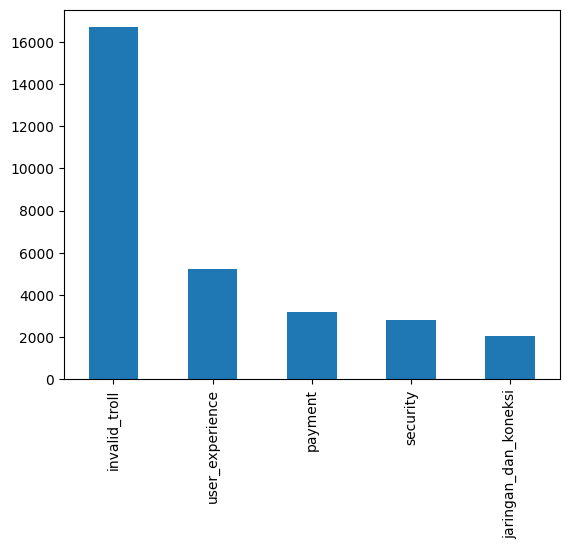

In [28]:
model_docs_lbl_similarities['most_similar_label'].value_counts().plot(kind='bar')

In [50]:
sentiment_dict = {}
for i in model_docs_lbl_similarities.iterrows():
    sentiment_dict[i[1]['most_similar_label']] = sentiment_dict.get(i[1]['most_similar_label'], 0) + i[1]['sentiment_score']
    # break

In [61]:
sentiment_dict

{'user_experience': -88314,
 'invalid_troll': -274340,
 'security': -60450,
 'jaringan_dan_koneksi': -33857,
 'payment': -64244}

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

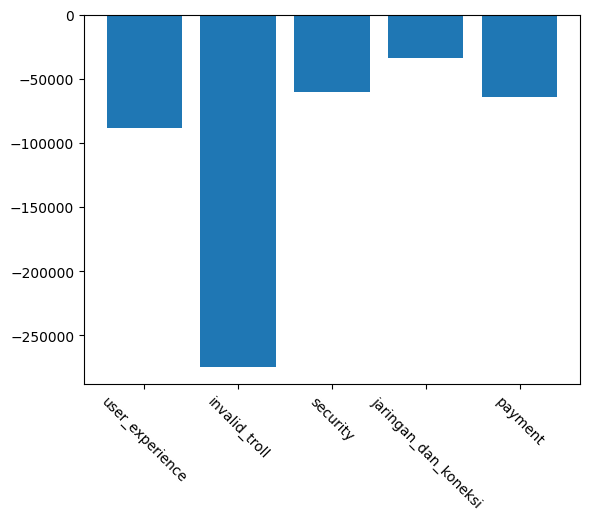

In [60]:
import matplotlib.pyplot as plt

plt.bar(sentiment_dict.keys(), sentiment_dict.values(), )
plt.xticks(rotation=-45)